In [ ]:
40

# Experiment 11: Binary Classification Algorithms Comparison using PySpark


## Objective
Compare three classification algorithms (Logistic Regression, SVM, Decision Tree) using precision, recall, and F1-score on Breast Cancer dataset (binary classification).

## 1. Import Libraries and Start Spark

In [ ]:
                                      # Import required libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, LinearSVC, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from sklearn.datasets import load_breast_cancer
import pandas as pd
import matplotlib.pyplot as plt

# Start Spark
spark = SparkSession.builder.appName("BinaryClassification").getOrCreate()

print("Spark is ready!")

Spark is ready!


## 2. Load Breast Cancer Dataset from CSV

Demonstrating loading from CSV - Breast Cancer dataset has 2 classes (Benign=0, Malignant=1)

In [ ]:
# Load Breast Cancer dataset (binary classification)
cancer = load_breast_cancer()
cancer_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
cancer_df['diagnosis'] = cancer.target  # 0 = malignant, 1 = benign

# Save to CSV file
cancer_df.to_csv('breast_cancer_dataset.csv', index=False)
print("Breast Cancer dataset CSV created successfully!")

# Load from CSV using PySpark
spark_df = spark.read.csv('breast_cancer_dataset.csv', header=True, inferSchema=True)

print(f"Dataset loaded from CSV with {spark_df.count()} samples")
print(f"Classes: 0=Malignant, 1=Benign")
print("\nFirst 5 rows:")
spark_df.select('mean radius', 'mean texture', 'mean perimeter', 'diagnosis').show(5)

Breast Cancer dataset CSV created successfully!
Dataset loaded from CSV with 569 samples
Classes: 0=Malignant, 1=Benign

First 5 rows:
+-----------+------------+--------------+---------+
|mean radius|mean texture|mean perimeter|diagnosis|
+-----------+------------+--------------+---------+
|      17.99|       10.38|         122.8|        0|
|      20.57|       17.77|         132.9|        0|
|      19.69|       21.25|         130.0|        0|
|      11.42|       20.38|         77.58|        0|
|      20.29|       14.34|         135.1|        0|
+-----------+------------+--------------+---------+
only showing top 5 rows



## 3. Verify Binary Dataset

In [ ]:
# Check class distribution
print("Class distribution:")
spark_df.groupBy('diagnosis').count().orderBy('diagnosis').show()

# Verify we have exactly 2 classes
num_classes = spark_df.select('diagnosis').distinct().count()
print(f"\nNumber of classes: {num_classes}")
print("✓ This is a binary classification dataset (2 classes)")

Class distribution:
+---------+-----+
|diagnosis|count|
+---------+-----+
|        0|  212|
|        1|  357|
+---------+-----+


Number of classes: 2
✓ This is a binary classification dataset (2 classes)


## 4. Prepare Data

In [ ]:
# Create feature vector using all columns except diagnosis
feature_cols = [col for col in spark_df.columns if col != 'diagnosis']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
assembled_df = assembler.transform(spark_df)

# Select only features and diagnosis (target)
final_df = assembled_df.select('features', 'diagnosis')

# Split data: 70% training, 30% testing
(train_data, test_data) = final_df.randomSplit([0.7, 0.3], seed=42)

print(f"Training data: {train_data.count()} samples")
print(f"Test data: {test_data.count()} samples")

Training data: 426 samples
Test data: 143 samples


## 5. Train Classification Models

In [ ]:
# Create three classifiers for binary classification
lr = LogisticRegression(featuresCol='features', labelCol='diagnosis')
svm = LinearSVC(featuresCol='features', labelCol='diagnosis', maxIter=10)
dt = DecisionTreeClassifier(featuresCol='features', labelCol='diagnosis')

# Train models
print("Training models...")
lr_model = lr.fit(train_data)
svm_model = svm.fit(train_data)
dt_model = dt.fit(train_data)
print("All models trained successfully!")

Training models...
All models trained successfully!


## 6. Make Predictions and Evaluate

In [ ]:
# Make predictions
lr_predictions = lr_model.transform(test_data)
svm_predictions = svm_model.transform(test_data)
dt_predictions = dt_model.transform(test_data)

# Create evaluators for binary classification
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol='diagnosis', predictionCol='prediction', metricName='weightedPrecision')
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol='diagnosis', predictionCol='prediction', metricName='weightedRecall')
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol='diagnosis', predictionCol='prediction', metricName='f1')

print("=== BINARY CLASSIFICATION RESULTS ===")
print("Dataset: Breast Cancer (2 classes: Malignant=0, Benign=1)\n")

# Store results
results = []

# Logistic Regression
lr_precision = precision_evaluator.evaluate(lr_predictions)
lr_recall = recall_evaluator.evaluate(lr_predictions)
lr_f1 = f1_evaluator.evaluate(lr_predictions)
results.append(['Logistic Regression', lr_precision, lr_recall, lr_f1])
print(f"Logistic Regression - Precision: {lr_precision:.3f}, Recall: {lr_recall:.3f}, F1: {lr_f1:.3f}")

# SVM (works with binary data)
svm_precision = precision_evaluator.evaluate(svm_predictions)
svm_recall = recall_evaluator.evaluate(svm_predictions)
svm_f1 = f1_evaluator.evaluate(svm_predictions)
results.append(['SVM', svm_precision, svm_recall, svm_f1])
print(f"SVM - Precision: {svm_precision:.3f}, Recall: {svm_recall:.3f}, F1: {svm_f1:.3f}")

# Decision Tree
dt_precision = precision_evaluator.evaluate(dt_predictions)
dt_recall = recall_evaluator.evaluate(dt_predictions)
dt_f1 = f1_evaluator.evaluate(dt_predictions)
results.append(['Decision Tree', dt_precision, dt_recall, dt_f1])
print(f"Decision Tree - Precision: {dt_precision:.3f}, Recall: {dt_recall:.3f}, F1: {dt_f1:.3f}")

=== BINARY CLASSIFICATION RESULTS ===
Dataset: Breast Cancer (2 classes: Malignant=0, Benign=1)

Logistic Regression - Precision: 0.958, Recall: 0.958, F1: 0.958
SVM - Precision: 0.961, Recall: 0.958, F1: 0.958
Decision Tree - Precision: 0.944, Recall: 0.944, F1: 0.944


## 7. Visualize Results

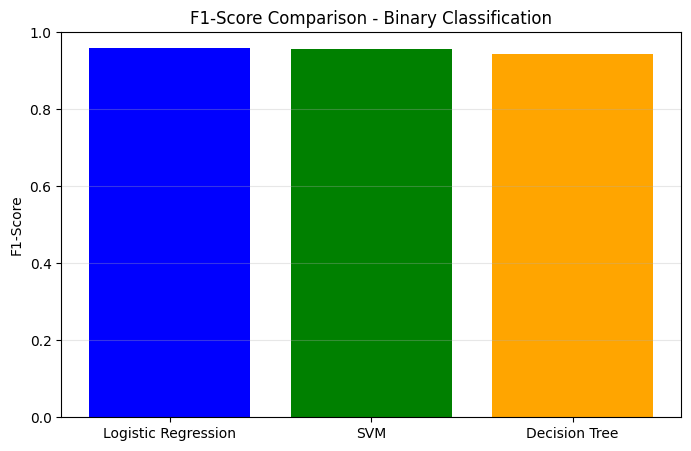


Best Algorithm: Logistic Regression with F1-Score: 0.958


In [ ]:
# Create simple comparison chart
algorithms = [result[0] for result in results]
f1_scores = [result[3] for result in results]

plt.figure(figsize=(8, 5))
plt.bar(algorithms, f1_scores, color=['blue', 'green', 'orange'])
plt.title('F1-Score Comparison - Binary Classification')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.show()

# Find and display best algorithm
best_index = f1_scores.index(max(f1_scores))
print(f"\nBest Algorithm: {algorithms[best_index]} with F1-Score: {f1_scores[best_index]:.3f}")

## 8. Show Sample Predictions

In [ ]:
# Show sample predictions from best model
print(f"Sample predictions from {algorithms[best_index]}:")
print("(0=Malignant, 1=Benign)\n")

if best_index == 0:  # Logistic Regression
    lr_predictions.select('diagnosis', 'prediction').show(10)
elif best_index == 1:  # SVM
    svm_predictions.select('diagnosis', 'prediction').show(10)
else:  # Decision Tree
    dt_predictions.select('diagnosis', 'prediction').show(10)

Sample predictions from Logistic Regression:
(0=Malignant, 1=Benign)

+---------+----------+
|diagnosis|prediction|
+---------+----------+
|        1|       1.0|
|        1|       1.0|
|        1|       1.0|
|        1|       1.0|
|        1|       1.0|
|        1|       1.0|
|        1|       1.0|
|        1|       1.0|
|        1|       1.0|
|        1|       1.0|
+---------+----------+
only showing top 10 rows



In [ ]:
# Stop Spark
spark.stop()
print("Experiment completed successfully!")

Experiment completed successfully!
